In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr,spearmanr
import itertools
from sklearn.cross_decomposition import CCA
import networkx as nx
import seaborn as sns
import pydot
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Instructions

**Before running this notebook:**

1. Run `Neighborhood Identification.ipynb` first to create neighborhoods
2. The Neighborhood Identification notebook will automatically save the results to:
   - `cells_with_neighborhoods.csv` (CSV format)
   - `cells_with_neighborhoods.pkl` (pickle format, faster to load)
3. This notebook will automatically load from the saved files

**Alternative:** If you're running both notebooks in the same Jupyter session, the cells dataframe will be available in memory and will be used automatically.


In [2]:
# Load data from saved file with neighborhoods
# The Neighborhood Identification.ipynb notebook creates neighborhoods and adds them to the cells dataframe
# You must save the cells dataframe after running that notebook by adding this code at the end:
#   cells.to_csv('cells_with_neighborhoods.csv', index=False)
#   # OR save as pickle (faster to load, preserves data types better):
#   # cells.to_pickle('cells_with_neighborhoods.pkl')

import os

# Check if cells variable exists in memory (if running notebooks in sequence)
if 'cells' in globals() and hasattr(cells, 'columns'):
    print("Using cells dataframe from current session (from Neighborhood Identification.ipynb)")
    # Check if it has neighborhood column
    neighborhood_cols_in_memory = [col for col in cells.columns if 'neighborhood' in col.lower()]
    if neighborhood_cols_in_memory:
        print(f"Found neighborhood columns in memory: {neighborhood_cols_in_memory}")
    else:
        print("Warning: cells dataframe exists but no neighborhood column found.")
else:
    # Check for saved files with neighborhoods
    saved_csv = 'cells_with_neighborhoods.csv'
    saved_pkl = 'cells_with_neighborhoods.pkl'
    
    if os.path.exists(saved_pkl):
        print(f"Loading from saved pickle file: {saved_pkl}")
        cells = pd.read_pickle(saved_pkl)
    elif os.path.exists(saved_csv):
        print(f"Loading from saved CSV file: {saved_csv}")
        cells = pd.read_csv(saved_csv)
    else:
        error_msg = (
            f"ERROR: Neither {saved_csv} nor {saved_pkl} found.\n\n"
            "Please run Neighborhood Identification.ipynb first to create neighborhoods.\n"
            "The notebook will automatically save the results to 'cells_with_neighborhoods.csv' and 'cells_with_neighborhoods.pkl'.\n"
            "After running that notebook completely (including the save cell), this notebook will be able to load the saved data.\n\n"
            "Note: main_fcs_csv.csv is the INPUT file and does not contain neighborhoods."
        )
        raise FileNotFoundError(error_msg)

# Check if neighborhood column exists (should be from Neighborhood Identification.ipynb)
# Look for neighborhood columns (e.g., neighborhood20, neighborhood10, etc.)
# 'neighborhood' is 12 characters, so we check from index 12 onwards for digits
neighborhood_cols = [col for col in cells.columns if col.startswith('neighborhood') and len(col) > 12 and col[12:].isdigit()]
# Also check for just 'neighborhood' followed by any digits (more flexible)
if not neighborhood_cols:
    # Try a more flexible approach: any column starting with 'neighborhood' that has additional characters
    neighborhood_cols = [col for col in cells.columns if col.startswith('neighborhood') and len(col) > 12]
if not neighborhood_cols:
    # Last resort: just look for any column with 'neighborhood' in the name
    neighborhood_cols = [col for col in cells.columns if 'neighborhood' in col.lower()]
if not neighborhood_cols:
    print("Available columns in the dataset:")
    print(cells.columns.tolist())
    raise ValueError("No neighborhood column found. Please run Neighborhood Identification.ipynb first to create neighborhoods.")
neighborhood_col = neighborhood_cols[0]  # Use the first one found
print(f"Using neighborhood column: {neighborhood_col}")

# Determine patient/region identifier
# Check if 'tile' column has multiple unique values (tiles from different patients)
if 'tile' in cells.columns:
    unique_tiles = cells['tile'].nunique()
    if unique_tiles > 1:
        patient_col = 'tile'
        cells['patients'] = cells['tile']  # Use tile as patient identifier
        print(f"Using 'tile' column as patient identifier ({unique_tiles} unique tiles)")
    else:
        print(f"Warning: 'tile' column has only {unique_tiles} unique value(s). All tiles appear to be from the same patient.")
        if 'patients' in cells.columns:
            patient_col = 'patients'
        else:
            # Use 'File Name' as patient identifier
            patient_col = 'File Name'
            cells['patients'] = cells['File Name']  # Create patients column for compatibility
            print(f"Warning: Using 'File Name' as patient identifier, but all values may be the same.")
else:
    if 'patients' in cells.columns:
        patient_col = 'patients'
    else:
        # Use 'File Name' as patient identifier
        patient_col = 'File Name'
        cells['patients'] = cells['File Name']  # Create patients column for compatibility
        print(f"Warning: Using 'File Name' as patient identifier. Please verify this column distinguishes different patients.")

# Check if groups column exists
if 'groups' in cells.columns:
    patient_to_group_dict = cells.loc[:,['patients','groups']].drop_duplicates().set_index('patients').to_dict()['groups']
    group1_patients = [a for a,gp in patient_to_group_dict.items() if gp==1]
    group2_patients = [a for a,gp in patient_to_group_dict.items() if gp==2]
    has_groups = True
    print(f"Found groups column. Group 1: {len(group1_patients)} patients, Group 2: {len(group2_patients)} patients")
else:
    has_groups = False
    print("No 'groups' column found. Will analyze all data together.")
    # Use all unique patients/regions
    all_patients = cells['patients'].unique().tolist()
    group1_patients = all_patients  # Use all for group1 analysis
    group2_patients = all_patients  # Use all for group2 analysis (will be same as group1)

Loading from saved pickle file: cells_with_neighborhoods.pkl
Using neighborhood column: neighborhood20
Using 'tile' column as patient identifier (17 unique tiles)
No 'groups' column found. Will analyze all data together.


In [3]:
# select which neighborhoods to analyze
# Get unique neighborhood values (should be 1-7 based on Neighborhood Identification.ipynb)
unique_neighborhoods = sorted([int(x) for x in cells[neighborhood_col].unique() if pd.notna(x)])
# Convert to 0-indexed for compatibility with original code (neighborhoods 1-7 become 0-6)
cns = [n-1 for n in unique_neighborhoods]  # Convert 1-indexed to 0-indexed
print(f"Neighborhoods found: {unique_neighborhoods} (using 0-indexed: {cns})")

# Get cell type columns (one-hot encoded from ClusterName)
# These should be created in Neighborhood Identification.ipynb
cluster_col = 'ClusterName'
if cluster_col not in cells.columns:
    raise ValueError(f"Column '{cluster_col}' not found. Please ensure data has been processed.")

# Find one-hot encoded cell type columns
# These are columns that were created from ClusterName (excluding the original ClusterName column)
# In Neighborhood Identification.ipynb, these are stored in sum_cols
# Exclude RGB columns (color_R, color_G, color_B) and type/type_prob as they are for visualization, not analysis
# RGB values are constant for all cells in the same CN, so they don't provide meaningful information for correlation
exclude_cols = ['X:X', 'Y:Y', 'File Name', 'patients', 'groups', neighborhood_col, 
                'type', 'type_prob', 'color_R', 'color_G', 'color_B', 'tile']
exclude_cols.extend([c for c in cells.columns if c.startswith('neighborhood')])

potential_cell_type_cols = [col for col in cells.columns 
                           if col != cluster_col 
                           and col not in exclude_cols
                           and cells[col].dtype in [np.float64, np.float32, np.int64, np.int32, np.float16, bool]]

# If we can't find them automatically, create one-hot encoding
if len(potential_cell_type_cols) == 0:
    print("Creating one-hot encoded cell type columns...")
    dummy_cols = pd.get_dummies(cells[cluster_col])
    cells = pd.concat([cells, dummy_cols], axis=1)
    subsets = dummy_cols.columns.tolist()
else:
    # Use existing one-hot encoded columns
    subsets = potential_cell_type_cols
    print(f"Using existing cell type columns: {subsets}")

print(f"Number of cell types: {len(subsets)}")
print(f"Cell types: {subsets}")

Neighborhoods found: [1, 2, 3, 4, 5, 6, 7, 8] (using 0-indexed: [0, 1, 2, 3, 4, 5, 6, 7])
Using existing cell type columns: ['Epithelium (PD-L1hi/ki67hi)', 'Epithelium (PD-L1lo/ki67lo)', 'Fibroblast/Stroma', 'Lymphocyte', 'Macrophage', 'Undefined', 'Vascular']
Number of cell types: 7
Cell types: ['Epithelium (PD-L1hi/ki67hi)', 'Epithelium (PD-L1lo/ki67lo)', 'Fibroblast/Stroma', 'Lymphocyte', 'Macrophage', 'Undefined', 'Vascular']


In [4]:
#log (1e-3 +  neighborhood specific cell type frequency) of cell types) ('nsctf')
# Note: neighborhood_col contains 1-indexed values (1-7), but we need to convert to 0-indexed for indexing
# Create a temporary 0-indexed neighborhood column for grouping
cells_temp = cells.copy()
cells_temp['neighborhood_0idx'] = cells_temp[neighborhood_col].astype(int) - 1

# Group by patients and neighborhood, then compute mean cell type frequencies
nsctf = np.log(1e-3 + cells_temp.groupby(['patients','neighborhood_0idx'])[subsets].mean().reset_index().set_index(['neighborhood_0idx','patients']))

print(f"nsctf shape: {nsctf.shape}")
print(f"nsctf index levels: {nsctf.index.names}")
print(f"Sample nsctf data:")
print(nsctf.head())

nsctf shape: (135, 7)
nsctf index levels: ['neighborhood_0idx', 'patients']
Sample nsctf data:
                                    Epithelium (PD-L1hi/ki67hi)  \
neighborhood_0idx patients                                        
0                 tile_15077_29493                    -0.553029   
1                 tile_15077_29493                    -2.416479   
2                 tile_15077_29493                    -2.720910   
3                 tile_15077_29493                    -3.955911   
4                 tile_15077_29493                    -2.893514   

                                    Epithelium (PD-L1lo/ki67lo)  \
neighborhood_0idx patients                                        
0                 tile_15077_29493                    -2.218484   
1                 tile_15077_29493                    -0.266957   
2                 tile_15077_29493                    -2.872532   
3                 tile_15077_29493                    -3.304318   
4                 tile_15077_2949

# CCA relative to permutations for group1
# Note: If no 'groups' column exists, this will analyze all patients/regions together

In [5]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group1 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            # Get available patients for each neighborhood
            patients_cn_i = nsctf.loc[cn_i].index
            patients_cn_j = nsctf.loc[cn_j].index
            
            # Find patients that exist in both neighborhoods AND are in group1_patients
            common_patients = list(set(patients_cn_i) & set(patients_cn_j) & set(group1_patients))
            
            if len(common_patients) == 0:
                print(f"Warning: No common patients found for neighborhoods {cn_i} and {cn_j} in group1. Skipping.")
                continue
            
            #concat dfs using only common patients
            combined = pd.concat([nsctf.loc[cn_i].loc[common_patients],nsctf.loc[cn_j].loc[common_patients]], axis = 1).dropna(axis = 0, how = 'any')
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components with respect to observed data
            ccx,ccy = cca.fit_transform(x,y)
            stats_group1[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                # compute with permuted data
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]





### visualization

# CCA relative to permutations for group2
# Note: If no 'groups' column exists, this will analyze all patients/regions together (same as group1)

In [6]:
cca = CCA(n_components=1,max_iter = 5000)
func = pearsonr

# set number of permutation params
n_perms = 5000
stats_group2 = {}

for cn_i in cns:
    for cn_j in cns:
        if cn_i < cn_j:

            # Get available patients for each neighborhood
            patients_cn_i = nsctf.loc[cn_i].index
            patients_cn_j = nsctf.loc[cn_j].index
            
            # Find patients that exist in both neighborhoods AND are in group2_patients
            common_patients = list(set(patients_cn_i) & set(patients_cn_j) & set(group2_patients))
            
            if len(common_patients) == 0:
                print(f"Warning: No common patients found for neighborhoods {cn_i} and {cn_j} in group2. Skipping.")
                continue
            
            #concat dfs using only common patients
            combined = pd.concat([nsctf.loc[cn_i].loc[common_patients],nsctf.loc[cn_j].loc[common_patients]], axis = 1).dropna(axis = 0, how = 'any')
            x = combined.iloc[:,:len(subsets)].values
            y = combined.iloc[:,len(subsets):].values

            arr = np.zeros(n_perms)

            #compute the canonical correlation achieving components
            ccx,ccy = cca.fit_transform(x,y)
            stats_group2[cn_i,cn_j] = (pearsonr(ccx[:,0],ccy[:,0])[0],arr)

            #initialize array for perm values

            for i in range(n_perms):
                idx = np.arange(len(x))
                np.random.shuffle(idx)
                cc_permx,cc_permy = cca.fit_transform(x[idx],y)
                arr[i] = pearsonr(cc_permx[:,0],cc_permy[:,0])[0]



### visualization

Threshold (p-value): 0.95
Visible edges: 8 out of 8 total analyzed
Correlation range of visible edges: 0.9962 to 0.9996
Correlation range of ALL analyzed edges: 0.9962 to 0.9996
P-value range of visible edges: 0.9558 to 0.9986

Note: Threshold filters by p-value (statistical significance), not correlation value.
      Lower threshold includes more edges, but their correlations may still be high.


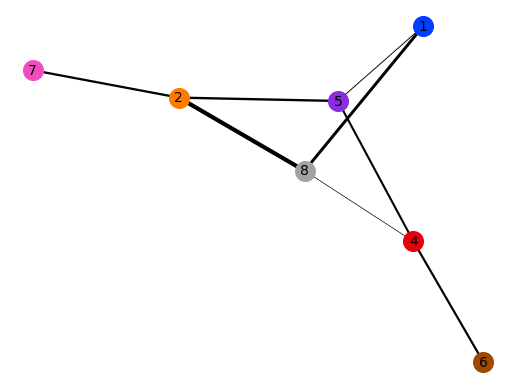

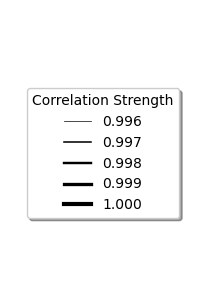

In [10]:
THRESHOLD = 0.95

g2 = nx.Graph()
# Store both p-value and observed correlation for each edge
edge_data = {}

for cn_pair, cc in stats_group2.items():
    s,t = cn_pair
    obs, perms = cc
    p = np.mean(obs > perms)
    if p > THRESHOLD:
        # Store observed correlation (the actual strength of the relationship)
        # obs is already the correlation coefficient (scalar) from pearsonr()[0]
        g2.add_edge(s, t, weight=p)
        edge_data[(s, t)] = {'p': p, 'corr': obs}

# Check if graph has any edges
if len(g2.edges()) == 0:
    print("No edges found in graph (no neighborhood pairs with p > 0.95)")
    plt.text(0.5, 0.5, 'No significant correlations found', ha='center', va='center', transform=plt.gca().transAxes)
else:
    pal = sns.color_palette('bright',10)
    dash = {True: '-', False: ':'}
    
    # Use spring_layout as a more reliable alternative to pydot_layout
    # Try kamada_kawai_layout first (better for small graphs), fallback to spring_layout
    try:
        pos = nx.kamada_kawai_layout(g2)
    except:
        pos = nx.spring_layout(g2, k=1, iterations=50)
    
    for k,v in pos.items():
        x,y = v
        plt.scatter([x],[y],c = [pal[k % len(pal)]], s = 200,zorder = 3)
        # Display 1-indexed labels (1-7) instead of 0-indexed (0-6)
        plt.text(x,y, k+1, fontsize = 10, zorder = 10,ha = 'center', va = 'center')

    # Get correlation values for all edges to normalize linewidth
    # Use absolute values since we care about strength, not direction
    # Normalize edge order since edge_data stores edges as (s, t) where s < t
    corr_values = [abs(edge_data[tuple(sorted((e0, e1)))]['corr']) for e0, e1 in g2.edges()]
    if len(corr_values) > 0:
        min_corr = min(corr_values)
        max_corr = max(corr_values)
        corr_range = max_corr - min_corr if max_corr != min_corr else 1.0
    else:
        min_corr = 0
        corr_range = 1.0
    
    for e0,e1 in g2.edges():
        # Normalize edge order since edge_data stores edges as (s, t) where s < t
        edge_key = tuple(sorted((e0, e1)))
        edge_info = edge_data[edge_key]
        corr = edge_info['corr']
        p = edge_info['p']
        
        # Normalize correlation to 0-1 range for visualization
        # Use absolute value since we care about strength, not direction
        abs_corr = abs(corr)
        normalized_corr = (abs_corr - min_corr) / corr_range if corr_range > 0 else 0.5
        
        # Use correlation strength for linewidth (creates better visual contrast)
        # Scale between 0.5 and 3.0 based on correlation strength
        linewidth_val = float(0.5 + 2.5 * normalized_corr)
        
        # Use p-value for alpha (transparency) - higher p = more opaque
        alpha_val = float(np.minimum(1.0, 0.5 + 0.5 * p))
        
        plt.plot([pos[e0][0],pos[e1][0]],[pos[e0][1],pos[e1][1]], 
                 c='black', alpha=alpha_val, linewidth=linewidth_val)
    
    # Remove axis numbers/labels since X and Y axes have no inherent meaning
    plt.axis('off')
    
    # Create a separate figure for the legend
    # Recalculate correlation range from CURRENT visible edges (those passing threshold)
    # This ensures legend updates when threshold changes
    # Normalize edge order since edge_data stores edges as (s, t) where s < t
    current_corr_values = [abs(edge_data[tuple(sorted((e0, e1)))]['corr']) for e0, e1 in g2.edges()]
    if len(current_corr_values) > 0:
        legend_min_corr = min(current_corr_values)
        legend_max_corr = max(current_corr_values)
        legend_corr_range = legend_max_corr - legend_min_corr if legend_max_corr != legend_min_corr else 1.0
    else:
        legend_min_corr = 0
        legend_corr_range = 1.0
    
    # Diagnostic output to help understand what's happening
    all_analyzed_corrs = [abs(edge_data[(e0, e1)]['corr']) for e0, e1 in edge_data.keys()]
    all_analyzed_pvals = [edge_data[(e0, e1)]['p'] for e0, e1 in edge_data.keys()]
    
    if len(current_corr_values) > 0:
        print(f"Threshold (p-value): {THRESHOLD}")
        print(f"Visible edges: {len(g2.edges())} out of {len(edge_data)} total analyzed")
        print(f"Correlation range of visible edges: {legend_min_corr:.4f} to {legend_max_corr:.4f}")
        if len(all_analyzed_corrs) > 0:
            print(f"Correlation range of ALL analyzed edges: {min(all_analyzed_corrs):.4f} to {max(all_analyzed_corrs):.4f}")
            print(f"P-value range of visible edges: {min([edge_data[tuple(sorted((e0, e1)))]['p'] for e0, e1 in g2.edges()]):.4f} to {max([edge_data[tuple(sorted((e0, e1)))]['p'] for e0, e1 in g2.edges()]):.4f}")
        print(f"\nNote: Threshold filters by p-value (statistical significance), not correlation value.")
        print(f"      Lower threshold includes more edges, but their correlations may still be high.")
    
    # Create sample lines with different thicknesses
    legend_lines = []
    legend_labels = []
    
    # Create 5 sample thicknesses covering the range
    num_legend_items = 5
    for i in range(num_legend_items):
        # Normalized correlation from 0 to 1
        norm_corr = i / (num_legend_items - 1) if num_legend_items > 1 else 0.5
        # Calculate linewidth (same formula as above)
        lw = 0.5 + 2.5 * norm_corr
        # Calculate actual correlation value for label based on current edges
        actual_corr = legend_min_corr + norm_corr * legend_corr_range
        
        # Create a line segment for the legend
        legend_line = plt.Line2D([0], [0], color='black', linewidth=lw, alpha=1.0)
        legend_lines.append(legend_line)
        legend_labels.append(f'{abs(actual_corr):.3f}')
    
    # Create a separate figure for the legend (compact size)
    fig_legend = plt.figure(figsize=(2, 3))
    ax_legend = fig_legend.add_subplot(111)
    ax_legend.axis('off')
    
    # Add legend
    legend = ax_legend.legend(legend_lines, legend_labels, 
                             title='Correlation Strength',
                             loc='center',
                             frameon=True,
                             fancybox=True,
                             shadow=True)
    legend.get_title().set_fontsize(10)
    
    # Minimize padding and make figure tight around legend
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.tight_layout(pad=0.5)
    plt.show()
